In [1]:
!pip install streamlit -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.1/9.1 MB 81.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 114.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 7.3 MB/s eta 0:00:00


In [16]:
import os
import glob
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import streamlit as st

In [3]:
# Define the base path
path = "/content/mamikos"

# Recursively search for all CSV files under the 'mamikos' folder
all_files = glob.glob(os.path.join(path, '**/*.csv'), recursive=True)

# Read only valid and non-empty CSV files
data_list = []
for file in all_files:
    try:
        # Attempt to read the file
        df = pd.read_csv(file)
        if not df.empty and df.columns.any():  # Ensure the DataFrame isn't empty
            data_list.append(df)
    except Exception as e:
        print(f"Skipping file {file} due to error: {e}")

# Combine valid DataFrames into a single DataFrame
if data_list:  # Only attempt concatenation if there are valid data files
    data = pd.concat(data_list, ignore_index=True)
    print("Combined data successfully.")
else:
    print("No valid data files were found.")

# Display the first few rows if data is available
if 'data' in locals() and not data.empty:
    print(data.head())
else:
    print("No data to display.")

Combined data successfully.
  Singgahsini Kos Andalan                                               Name  \
0           -           -  Kost Jemur Ngawinan Ismanto Tipe kamar Wonocol...   
1           -           -                 Kost Mbak Tri Tipe A Waru Sidoarjo   
2           -           -                       Kost Mbak Dian Waru Sidoarjo   
3           -           -                        Kost Nafisyah Waru Sidoarjo   
4           -           -                  Kost Pak Rudi Waru Taman Sidoarjo   

   K. Mandi Dalam   WiFi     AC  Kloset Duduk  Kasur  Akses 24 Jam  \
0           False  False  False         False   True          True   
1           False  False  False         False  False          True   
2           False  False  False         False   True          True   
3           False  False  False         False   True          True   
4           False  False  False          True   True          True   

   Availability  Rating      Price  Kost Raw Value  
0  Sisa 2 kamar  

In [4]:
# Convert Price to numeric
data['Price'] = data['Price'].replace('[^\d]', '', regex=True).astype(float)

# Drop rows with missing values in critical columns
data = data.dropna(subset=['Price', 'Kost Raw Value'])

# Display summary
print(data.info())

<class 'pandas.core.frame.DataFrame'>
Index: 1825 entries, 0 to 2134
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Singgahsini     1825 non-null   object 
 1   Kos Andalan     1825 non-null   object 
 2   Name            1825 non-null   object 
 3   K. Mandi Dalam  1825 non-null   bool   
 4   WiFi            1825 non-null   bool   
 5   AC              1825 non-null   bool   
 6   Kloset Duduk    1825 non-null   bool   
 7   Kasur           1825 non-null   bool   
 8   Akses 24 Jam    1825 non-null   bool   
 9   Availability    1820 non-null   object 
 10  Rating          1825 non-null   int64  
 11  Price           1825 non-null   float64
 12  Kost Raw Value  1825 non-null   float64
dtypes: bool(6), float64(2), int64(1), object(4)
memory usage: 124.8+ KB
None


In [5]:
scaler = MinMaxScaler()
data[['Price Normalized']] = scaler.fit_transform(data[['Price']])

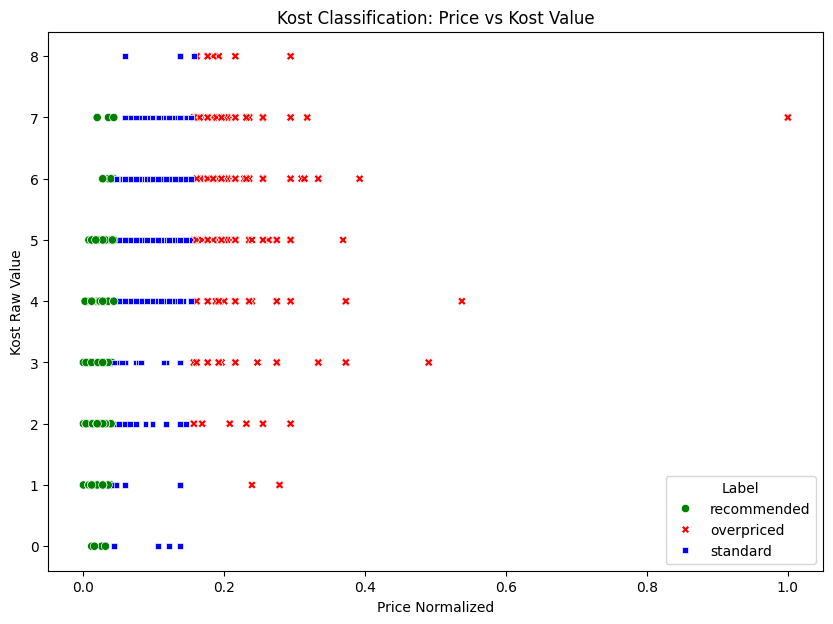

0       recommended
1       recommended
2       recommended
3       recommended
4       recommended
           ...     
2130     overpriced
2131     overpriced
2132     overpriced
2133     overpriced
2134     overpriced
Name: Label, Length: 1825, dtype: object
0       5.972378e+05
1       6.221953e+05
2       5.972378e+05
3       6.223228e+05
4       6.224502e+05
            ...     
2130   -4.529039e+05
2131   -5.779016e+05
2132   -4.529039e+05
2133   -5.529114e+05
2134   -1.702921e+06
Name: Score, Length: 1825, dtype: float64


In [6]:
# Compute mean price for relative comparison
mean_price = data['Price'].mean()

# Define custom scoring function
lambda_penalty = 0.5  # Penalty factor for overpriced items
data['Relative Price Diff'] = data['Price'] - mean_price  # Difference from mean price
data['Score'] = (data['Kost Raw Value'] / (data['Price Normalized'] + 1e-6)) - (lambda_penalty * data['Relative Price Diff'])

# Classify labels based on score
thresholds = {
    'recommended': data['Score'].quantile(0.75),  # Top 25% scores
    'standard': data['Score'].quantile(0.25),     # Bottom 25% scores
}
data['Label'] = data['Score'].apply(
    lambda x: 'recommended' if x >= thresholds['recommended']
    else 'overpriced' if x <= thresholds['standard']
    else 'standard'
)

# Visualization
plt.figure(figsize=(10, 7))
sns.scatterplot(
    data=data,
    x='Price Normalized',
    y='Kost Raw Value',
    hue='Label',
    style='Label',
    palette={'recommended': 'green', 'standard': 'blue', 'overpriced': 'red'}
)
plt.title("Kost Classification: Price vs Kost Value")
plt.xlabel("Price Normalized")
plt.ylabel("Kost Raw Value")
plt.legend(title="Label")
plt.show()

print(data['Label'])
print(data['Score'])

Cluster Centers:
Price Normalized, Kost Raw Value, Relative Price Diff
[[ 2.88168545e-01  5.23958333e+00  2.33001336e+06]
 [ 5.20736543e-02  4.41602317e+00 -6.80196495e+05]
 [ 1.59860595e-01  5.83549784e+00  6.94086994e+05]]


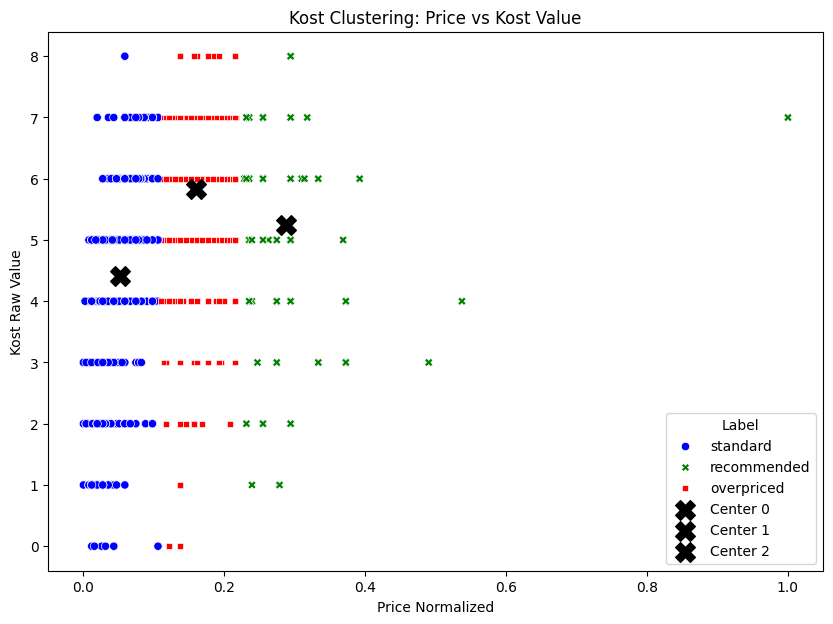

In [7]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns

# Normalize the Price feature
scaler = MinMaxScaler()
data[['Price Normalized']] = scaler.fit_transform(data[['Price']])

# Compute Relative Price Difference
mean_price = data['Price'].mean()
data['Relative Price Diff'] = data['Price'] - mean_price

# Prepare data for clustering
features = data[['Price Normalized', 'Kost Raw Value', 'Relative Price Diff']]

# Apply K-Means Clustering
kmeans = KMeans(n_clusters=3, random_state=42)
data['Cluster'] = kmeans.fit_predict(features)

# Retrieve cluster centers
centers = kmeans.cluster_centers_

# Map cluster numbers to labels
cluster_labels = {0: 'recommended', 1: 'standard', 2: 'overpriced'}
data['Label'] = data['Cluster'].map(cluster_labels)

# Print cluster centers
print("Cluster Centers:")
print(f"Price Normalized, Kost Raw Value, Relative Price Diff\n{centers}")

# Visualization
plt.figure(figsize=(10, 7))
sns.scatterplot(
    data=data,
    x='Price Normalized',
    y='Kost Raw Value',
    hue='Label',
    style='Label',
    palette={'recommended': 'green', 'standard': 'blue', 'overpriced': 'red'}
)
# Plot cluster centers
for idx, center in enumerate(centers):
    plt.scatter(center[0], center[1], s=200, c='black', marker='X', label=f'Center {idx}')

plt.title("Kost Clustering: Price vs Kost Value")
plt.xlabel("Price Normalized")
plt.ylabel("Kost Raw Value")
plt.legend(title="Label")
plt.show()


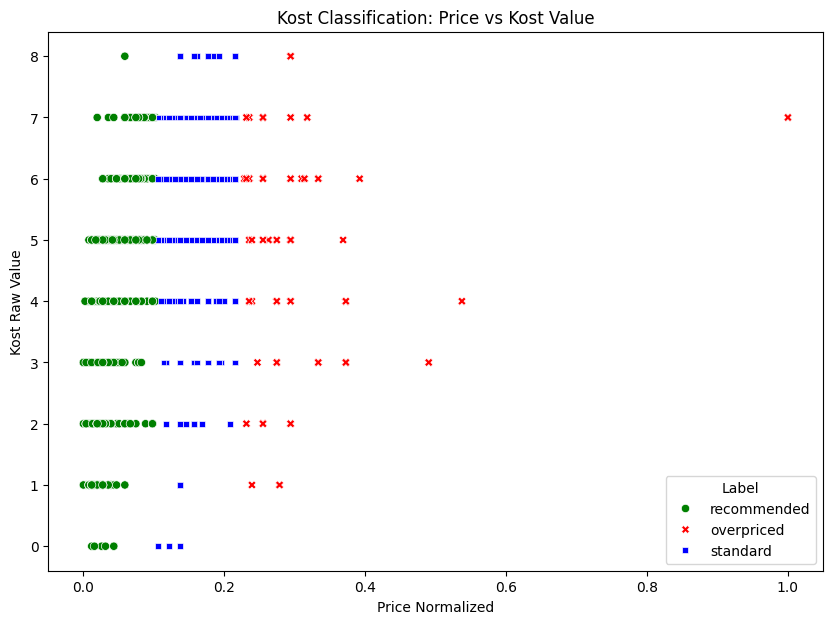

            Label RF_Prediction         Score
0     recommended   recommended  5.972378e+05
1     recommended   recommended  6.221953e+05
2     recommended   recommended  5.972378e+05
3     recommended   recommended  6.223228e+05
4     recommended   recommended  6.224502e+05
...           ...           ...           ...
2130     standard      standard -4.529039e+05
2131     standard      standard -5.779016e+05
2132     standard      standard -4.529039e+05
2133     standard      standard -5.529114e+05
2134   overpriced    overpriced -1.702921e+06

[1825 rows x 3 columns]


In [8]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Normalize the Price column
scaler = MinMaxScaler()
data['Price Normalized'] = scaler.fit_transform(data[['Price']])

# Compute additional features
mean_price = data['Price'].mean()
lambda_penalty = 0.5
data['Relative Price Diff'] = data['Price'] - mean_price
data['Score'] = (data['Kost Raw Value'] / (data['Price Normalized'] + 1e-6)) - (lambda_penalty * data['Relative Price Diff'])

# Features for clustering
features = data[['Price Normalized', 'Kost Raw Value', 'Relative Price Diff', 'Score']]

# Apply clustering (e.g., KMeans)
kmeans = KMeans(n_clusters=3, random_state=42)
data['Cluster'] = kmeans.fit_predict(features)

# Map clusters to labels (based on mean score for each cluster)
cluster_means = data.groupby('Cluster')['Score'].mean().sort_values()
cluster_to_label = {
    cluster_means.idxmax(): 'recommended',
    cluster_means.idxmin(): 'overpriced',
    cluster_means.index.difference([cluster_means.idxmax(), cluster_means.idxmin()])[0]: 'standard',
}
data['Label'] = data['Cluster'].map(cluster_to_label)

# Train Random Forest Classifier
X = features
y = data['Label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

# Predict on test data
data['RF_Prediction'] = rf_model.predict(X)

# Visualization
plt.figure(figsize=(10, 7))
sns.scatterplot(
    data=data,
    x='Price Normalized',
    y='Kost Raw Value',
    hue='Label',
    style='Label',
    palette={'recommended': 'green', 'standard': 'blue', 'overpriced': 'red'}
)
plt.title("Kost Classification: Price vs Kost Value")
plt.xlabel("Price Normalized")
plt.ylabel("Kost Raw Value")
plt.legend(title="Label")
plt.show()

# Print results
print(data[['Label', 'RF_Prediction', 'Score']])


In [25]:
# Preprocessing and Clustering
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import pickle

# Normalize the Price column
scaler = MinMaxScaler()
data['Price Normalized'] = scaler.fit_transform(data[['Price']])

# Compute additional features
mean_price = data['Price'].mean()
lambda_penalty = 0.5
data['Relative Price Diff'] = data['Price'] - mean_price
data['Score'] = (data['Kost Raw Value'] / (data['Price Normalized'] + 1e-6)) - (lambda_penalty * data['Relative Price Diff'])

# Features for clustering
features = data[['Price Normalized', 'Kost Raw Value', 'Relative Price Diff', 'Score']]

# Apply clustering
kmeans = KMeans(n_clusters=3, random_state=42)
data['Cluster'] = kmeans.fit_predict(features)

# Map clusters to labels
cluster_means = data.groupby('Cluster')['Score'].mean().sort_values()
cluster_to_label = {
    cluster_means.idxmax(): 'recommended',
    cluster_means.idxmin(): 'overpriced',
    cluster_means.index.difference([cluster_means.idxmax(), cluster_means.idxmin()])[0]: 'standard',
}
data['Label'] = data['Cluster'].map(cluster_to_label)

# Train Random Forest Classifier
X = features
y = data['Label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

# Predict on test data
data['RF_Prediction'] = rf_model.predict(X)

# Save artifacts
with open('rf_model.pkl', 'wb') as model_file:
    pickle.dump(rf_model, model_file)

with open('scaler.pkl', 'wb') as scaler_file:
    pickle.dump(scaler, scaler_file)

# Save processed data
output_path = "/content/mamikos_balanced.csv"
data.to_csv(output_path, index=False)
print(f"Processed data saved to {output_path}")

Processed data saved to /content/mamikos_balanced.csv


In [ ]:
# Streamlit App
%%writefile app.py
import streamlit as st
import pickle
import numpy as np

# Load model and scaler
with open('rf_model.pkl', 'rb') as model_file:
    rf_model = pickle.load(model_file)

with open('scaler.pkl', 'rb') as scaler_file:
    scaler = pickle.load(scaler_file)

# Static mean price (precomputed)
mean_price = 250000  # Replace with your actual mean

st.title("Kost Classification Predictor")
st.write("Predict whether a kost is 'recommended,' 'standard,' or 'overpriced' based on its value and price.")

# User inputs
kost_raw_value = st.number_input("Enter Kost Raw Value:", min_value=0.0, step=0.1)
price = st.number_input("Enter Price:", min_value=0.0, step=0.1)

if st.button("Predict"):
    # Preprocess inputs
    price_normalized = scaler.transform([[price]])[0, 0]
    relative_price_diff = price - mean_price
    score = (kost_raw_value / (price_normalized + 1e-6)) - (0.5 * relative_price_diff)

    # Create feature array
    features = np.array([[price_normalized, kost_raw_value, relative_price_diff, score]])

    # Predict
    prediction = rf_model.predict(features)[0]

    st.write(f"The predicted classification for the kost is: **{prediction}**")

In [27]:
!wget -q -O - ipv4.icanhazip.com

34.19.90.148


In [ ]:
!streamlit run app.py & npx localtunnel --port 8501



⠙⠹⠸
  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8501
  Network URL: http://172.28.0.12:8501
  External URL: http://34.19.90.148:8501

⠼⠴your url is: https://nine-kiwis-retire.loca.lt
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.